In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import FeatureUnion

In [2]:
class LinearSarsaAgent:
    def __init__(self, env: gym.Env, num_episodes: int = 1000, alpha: float = 0.01, epsilon: float = 0.1, decay: float = 0.9, sigma: float = 1, gamma_min: float = 0.05, gamma_max: float = 4.0, gamma_count: int = 10, components: int = 250) -> None:
        self.env: gym.Env = env
        self.num_episodes: int = num_episodes
        self.alpha: float = alpha
        self.epsilon: float = epsilon
        self.gamma: float = decay
        self.sigma: float = sigma
        self.action_space: npt.NDArray = np.arange(3)

        transformers = [RBFSampler(n_components=components, gamma=g) for g in np.linspace(gamma_min, gamma_max, gamma_count)]
        state = self.env.reset()[0]
        self.transformers: FeatureUnion = FeatureUnion([(str(t), t) for t in transformers])
        self.transformers.fit(state.reshape(1, -1))
        self.weights: npt.NDArray = np.zeros((self.action_space.shape[0], gamma_count * components))

    def transform(self, state: npt.NDArray) -> npt.NDArray:
        return np.ravel(self.transformers.transform(state.reshape(1, -1)))

    def approximate(self, state: npt.NDArray, action: int) -> float:
        state = self.transform(state)
        return np.dot(state, self.weights[action])

    def policy(self, state: npt.NDArray) -> int:
        if np.random.uniform() > self.epsilon:
            return np.argmax([self.approximate(state, action) for action in self.action_space])
        else:
            return self.env.action_space.sample()

    def train(self) -> list[int]:
        life = []
        for episode in range(self.num_episodes):
            state, _ = self.env.reset()
            action = self.policy(state)
            counter = 0
            while True:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                counter += 1

                q = self.approximate(state, action)
                q_gradient = self.transform(state)

                if terminated or truncated:
                    self.weights[action] += self.alpha * (reward - q) * q_gradient
                    break
                
                next_action = self.policy(next_state)
                q_next = self.approximate(next_state, next_action)
                self.weights[action] += self.alpha * (reward + self.gamma * q_next - q) * q_gradient

                state = next_state
                action = next_action
            
            life.append(counter)
        
        return life

In [3]:
env = gym.make("MountainCar-v0")
agent = LinearSarsaAgent(env)
info = agent.train()

Text(0, 0.5, 'Lifespan (# steps)')

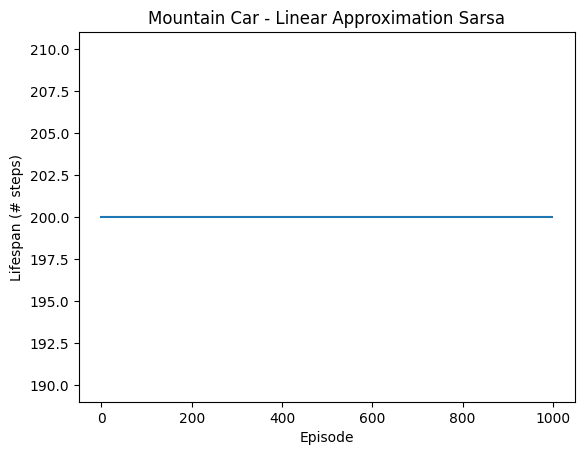

In [4]:
plt.plot(range(len(info)), info)
plt.title("Mountain Car - Linear Approximation Sarsa")
plt.xlabel("Episode")
plt.ylabel("Lifespan (# steps)")     